<a href="https://colab.research.google.com/github/SamAdebisi/Computer-Vision-using-PyTorch/blob/main/models/densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
# Define transformations for the training and test sets
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Human Action Recognition.zip to Human Action Recognition.zip


In [4]:
import zipfile
import os

# Update the path to the correct location of the zip file
zip_file_path = 'Human Action Recognition.zip'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Update extraction path if needed
    extraction_path = ''
    zip_ref.extractall(extraction_path)

# Update paths accordingly
train_data_path = 'Human Action Recognition/train'
test_data_path = 'Human Action Recognition/test'

In [5]:
#Apply the transforms to the train and test data
train_data = datasets.ImageFolder(root=train_data_path, transform=transform)
test_data = datasets.ImageFolder(root=test_data_path, transform=transform)

In [6]:
# Create DataLoader for training and test sets
train_loader = DataLoader(train_data, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
import torchvision.models as models
import torch
import torch.nn as nn
import torch.optim as optim

# Load DenseNet121
model = models.densenet121(pretrained=True)

# Freeze all the feature extraction layers
for param in model.features.parameters():
    param.requires_grad = False

# Freeze all the classification layers except the last one
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, 5)

# Unfreeze the last classification layer
for param in model.classifier.parameters():
    param.requires_grad = True

# Move the model to the device
model = model.to(device)

print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 124MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [8]:
# Define loss function and optimizer (only train the last classification layer)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=0.005)

In [9]:
import matplotlib.pyplot as plt

# Initialize the lists to store train and test loss for each epoch
train_losses = []
test_losses = []

# Train the model
num_epochs = 20
best_loss = torch.inf
patience = 5
epochs_since_best = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        if isinstance(outputs, tuple):
            outputs = outputs[0]  # For models that return auxiliary outputs
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)  # Store the train loss for this epoch
    train_accuracy = 100. * correct / total

    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')

    # Evaluate on the test set
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if isinstance(outputs, tuple):
                outputs = outputs[0]  # For models that return auxiliary outputs
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)  # Store the test loss for this epoch
    test_accuracy = 100. * correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    # Check for best accuracy and stop if not improved after five more epochs
    if test_loss < best_loss:
        best_loss = test_loss
        epochs_since_best = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save the model
        print(f'Updated best model with accuracy: {test_accuracy:.2f}%')
    else:
        epochs_since_best += 1
        if epochs_since_best > patience:
            print("Stopping early: no improvement after five consecutive epochs.")
            break

Epoch [1/20], Train Loss: 0.5751, Train Accuracy: 78.35%
Test Loss: 0.2877, Test Accuracy: 90.32%
Updated best model with accuracy: 90.32%
Epoch [2/20], Train Loss: 0.3623, Train Accuracy: 86.95%
Test Loss: 0.2360, Test Accuracy: 91.43%
Updated best model with accuracy: 91.43%
Epoch [3/20], Train Loss: 0.3065, Train Accuracy: 89.55%
Test Loss: 0.2839, Test Accuracy: 90.79%
Epoch [4/20], Train Loss: 0.2828, Train Accuracy: 89.72%
Test Loss: 0.3520, Test Accuracy: 89.37%
Epoch [5/20], Train Loss: 0.2886, Train Accuracy: 89.47%
Test Loss: 0.3577, Test Accuracy: 89.21%
Epoch [6/20], Train Loss: 0.2816, Train Accuracy: 89.83%
Test Loss: 0.2471, Test Accuracy: 91.11%
Epoch [7/20], Train Loss: 0.2528, Train Accuracy: 91.09%
Test Loss: 0.2661, Test Accuracy: 89.84%
Epoch [8/20], Train Loss: 0.2284, Train Accuracy: 91.96%
Test Loss: 0.2846, Test Accuracy: 89.68%
Stopping early: no improvement after five consecutive epochs.


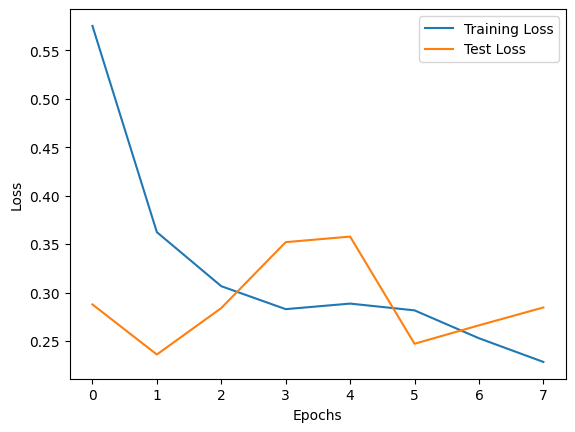

In [10]:
# Plotting the epochs vs training and test losses
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

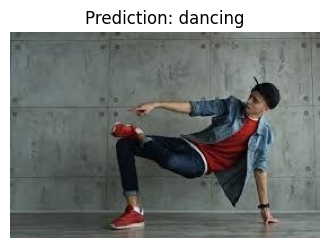

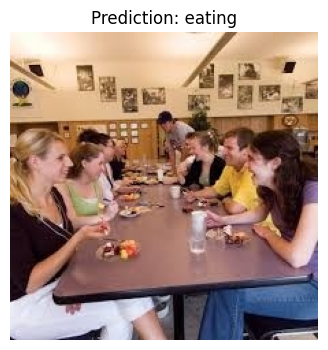

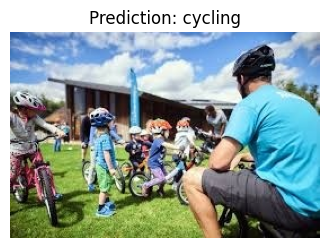

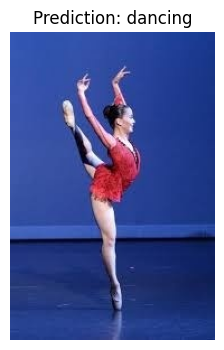

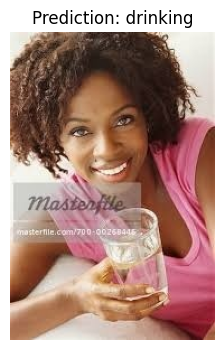

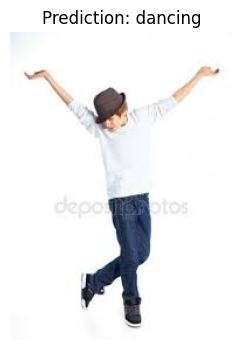

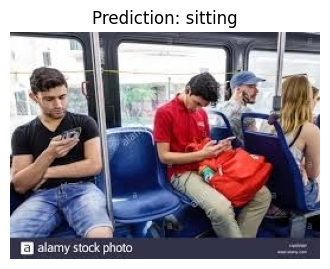

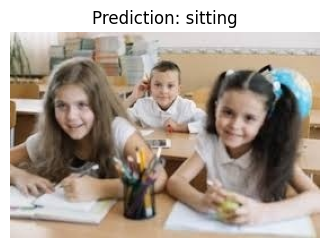

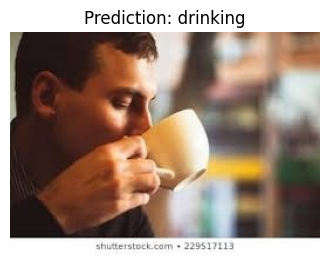

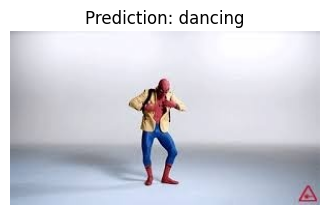

In [11]:
from PIL import Image
import random

# Create label index-to-name map
output_label_map = {v: k for k, v in test_data.class_to_idx.items()}

# Randomly select 10 indices from the dataset
sample_indices = random.sample(range(len(test_data)), 10)

# Loop over sampled indices
for idx in sample_indices:
    # Get full image path using ImageFolder's internal sample list
    img_path = test_data.samples[idx][0]  # sample = (image_path, label_index)

    # Open the original image (before transform, for visualization)
    image_true = Image.open(img_path)

    # Transform the image and add a batch dimension
    image = transform(image_true).unsqueeze(0).to(device)

    # Run the model without computing gradients
    with torch.no_grad():
        output = model(image)

    # Get the predicted class index
    predicted_class = torch.argmax(output, dim=1).item()

    # Plot the image and prediction
    plt.figure(figsize=(4, 4))
    plt.imshow(image_true)
    plt.title(f'Prediction: {output_label_map[predicted_class]}')
    plt.axis('off')
    plt.show()